In [1]:
import numpy as np
import pandas as pd
import scipy.io as sio
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# 1.Dataset Preparation and Visualization

### 1.1 Read data

In [2]:
data = sio.loadmat("./ex3/ex3data1.mat")
print(data.keys())
raw_X,raw_y = data["X"],data["y"]
print(raw_X.shape,raw_y.shape) # the input is a picture that has 20*20 pixls

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])
(5000, 400) (5000, 1)


### 1.2 Visualize data

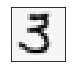

In [3]:
def plot_an_image(X):
    rand_ix = np.random.randint(5000)
    image = X[rand_ix,:]
    fig,ax = plt.subplots(figsize = (1,1))
    ax.imshow(image.reshape(20,20).T,cmap = "gray_r") #reshape to a 20*20 image
    plt.xticks([])
    plt.yticks([])
    
plot_an_image(raw_X)    

(100, 400)


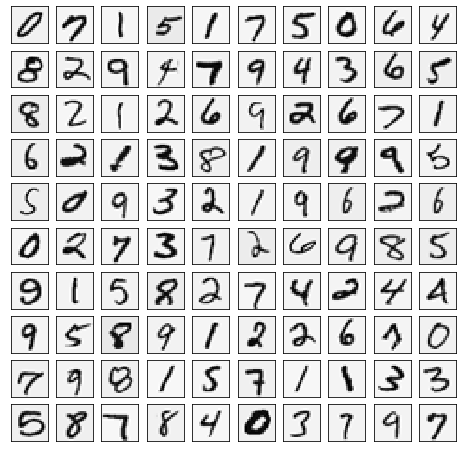

In [4]:
def plot_100_image(X):
    rand_ix = np.random.choice(len(X),100) # randomly pick 100 from 5000
    images = X[rand_ix,:]
    print(images.shape)
    fig,ax = plt.subplots(ncols=10, nrows=10, figsize = (8,8),sharex =True, sharey=True)
    for row in range(10):
        for col in range(10):
            ax[row,col].imshow(images[10*row + col].reshape(20,20).T,cmap = "gray_r") # (0,1),(0,2)(1,0)(1,1)...(100,100)
            
    plt.xticks([])
    plt.yticks([])
    plt.show
    
plot_100_image(raw_X)

In [5]:
raw_X.shape

(5000, 400)

## 2. Model Implementation

### 2.1 Sigmoid Function
$$h(z) = \frac{1}{(1 + e^{-z})} $$

In [6]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

### 2.2 Cost Function
$$J(\theta) = \frac{1}{m}[-y*log(h(x^{(i)})) - (1-y)*log(1-h(x^{(i)}))] + \frac{\lambda}{2m}\sum_{j = 1}^n \theta^2_j$$

In [61]:
def costFunc(theta,X,y,Lambda):
    m = len(X)
    first = -1 * y * np.log(sigmoid(X@theta))
    second = -1 *(1-y) * (np.log(1-sigmoid(X@theta)))
    reg = Lambda/(2*m)  * (theta[1:] @ theta[1:])
    return np.sum(first + second)/m + reg

### 2.3 Gradient Vector
$$ \frac{\partial J(\theta)}{\partial \theta_j}= (\frac{1}{m} \sum_{i=1}^m (h(x^{(i)} - y)x^{(i)}_j) + \frac{\lambda}{m} \theta_j$$

In [62]:
def gradient(theta, X, y, Lambda):
    m = len(X)
    reg  = Lambda/m * theta[1:]
    reg = np.insert(reg, 0, values = 0, axis = 0)
    first = (X.T@ (sigmoid(X@theta) - y))/len(X)    
    return first + reg   

In [63]:
X = np.insert(raw_X, 0 ,values = 1, axis = 1)
y = raw_y.flatten()
print(X.shape,y.shape)

(5000, 401) (5000,)


### 2.4 Gradient Descent via Scipy.Optimize.Minimize()

In [64]:
def one_vs_all(X,y,Lambda,K):
    n = X.shape[1]
    theta_all = np.zeros((K,n))
    for i in range(1,K+1):
        theta_i = np.zeros(n,) #the theta of clf[i]
        result = minimize(fun = costFunc,
                         x0 = theta_i,
                         args = (X,y == i ,Lambda),
                         method = "TNC",
                         jac = gradient)
        theta_all[i-1,:]=result.x #best param of i stored in row i -1
    return  theta_all

In [65]:
Lambda =1
K = 10
theta_final = one_vs_all(X,y,Lambda,K)

In [66]:
theta_final

array([[-2.38187334e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.30433279e-03, -7.29580949e-10,  0.00000000e+00],
       [-3.18303389e+00,  0.00000000e+00,  0.00000000e+00, ...,
         4.46340729e-03, -5.08870029e-04,  0.00000000e+00],
       [-4.79638233e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -2.87468695e-05, -2.47395863e-07,  0.00000000e+00],
       ...,
       [-7.98700752e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -8.94576566e-05,  7.21256372e-06,  0.00000000e+00],
       [-4.57358931e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.33390955e-03,  9.96868542e-05,  0.00000000e+00],
       [-5.40542751e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.16613537e-04,  7.88124085e-06,  0.00000000e+00]])

# 3. Evaluation

In [60]:
def predict(X,theta_final):
    h = sigmoid(X@theta_final.T) #X(5000,401)(10,401).T ==> (5000,10)
    h_argmax= np.argmax(h,axis = 1)
    return h_argmax+1 # to match index with clf number

In [69]:
y_pred = predict(X,theta_final)
acc = np.mean(y_pred == y)
acc

0.9446

The Accuracy is around 94.5%